In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import CRS
import requests
from pyproj import CRS

In [6]:
url = "https://noaa-goes16.s3.amazonaws.com/ABI-L1b-RadC/2021/001/00/OR_ABI-L1b-RadC-M6C02_G16_s20210010001176_e20210010003549_c20210010003583.nc"
filename = "OR_ABI-L1b-RadC.nc"

response = requests.get(url)
with open(filename, 'wb') as f:
    f.write(response.content)

In [11]:
# Open the dataset using xarray
ds = xr.open_dataset(filename)

# Step 2: Extract the relevant data (radiance and projection coordinates)
radiance = ds['Rad'].data  # Radiance data
x = ds['x'].data  # Geostationary x coordinates
y = ds['y'].data  # Geostationary y coordinates
satellite_height = 35786023  # Satellite height in meters
x_meters = x * satellite_height
y_meters = y * satellite_height

In [12]:
src_crs = CRS.from_wkt('PROJCRS["unnamed", \
    BASEGEOGCRS["unknown", \
        DATUM["unnamed", \
            ELLIPSOID["Spheroid",6378137,298.2572221, \
                LENGTHUNIT["metre",1, \
                    ID["EPSG",9001]]]], \
        PRIMEM["Greenwich",0, \
            ANGLEUNIT["degree",0.0174532925199433, \
                ID["EPSG",9122]]]], \
    CONVERSION["unknown", \
        METHOD["Geostationary Satellite (Sweep X)"], \
        PARAMETER["Longitude of natural origin",-75, \
            ANGLEUNIT["degree",0.0174532925199433, \
            ID["EPSG",8802]]], \
        PARAMETER["Satellite Height",35786023, \
            LENGTHUNIT["metre",1, \
                ID["EPSG",9001]]], \
        PARAMETER["False easting",0, \
            LENGTHUNIT["metre",1, \
                ID["EPSG",8806]]], \
        PARAMETER["False northing",0, \
            LENGTHUNIT["metre",1, \
                ID["EPSG",8807]]]], \
    CS[Cartesian,2], \
        AXIS["easting",east, \
            ORDER[1], \
            LENGTHUNIT["metre",1, \
                ID["EPSG",9001]]], \
        AXIS["northing",north, \
            ORDER[2], \
            LENGTHUNIT["metre",1, \
                ID["EPSG",9001]]], \
    REMARK["PROJ CRS string: +proj=geos +lon_0=-75 +h=35786023 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs +sweep=x"]]')
    
# Define the target CRS (EPSG:4326 - WGS84)
dst_crs = CRS.from_epsg(4326)

# Step 3: Reproject the radiance data from geostationary projection to EPSG:4326
# Create an in-memory rasterio dataset for the radiance data
ttransform = rasterio.transform.from_bounds(x_meters.min(), y_meters.min(), x_meters.max(), y_meters.max(), radiance.shape[1], radiance.shape[0])

# Define metadata for the input dataset
src_transform = transform
src_shape = radiance.shape
dst_shape = radiance.shape  # Same shape after reprojection
dst_transform, width, height = calculate_default_transform(src_crs, dst_crs, src_shape[1], src_shape[0], *rasterio.transform.array_bounds(src_shape[0], src_shape[1], src_transform))

# Initialize an array to store the reprojected data
reprojected_radiance = np.empty((height, width), dtype=np.float32)


In [15]:
# Reproject the data using rasterio
reproject(
    source=radiance,
    destination=reprojected_radiance,
    src_transform=src_transform,
    src_crs=src_crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest
)

(array([[[           nan,            nan,            nan, ...,
           9.9124908e-03, -3.0727196e-01,  6.4428139e-01],
         [           nan,            nan,            nan, ...,
          -4.6586418e-01, -1.4867973e-01,  3.2709694e-01],
         [           nan,            nan,            nan, ...,
           6.4428139e-01, -7.8304863e-01,  8.0287361e-01],
         ...,
         [ 5.6151611e+01,  5.0125107e+01,  4.3147041e+01, ...,
           9.9124908e-03, -4.6586418e-01,  9.6146584e-01],
         [ 5.9640648e+01,  6.1067978e+01,  4.3940002e+01, ...,
           1.6850471e-01, -7.8304863e-01,  4.8568916e-01],
         [ 5.9640648e+01,  6.9631966e+01,  4.8221992e+01, ...,
           1.6850471e-01, -4.6586418e-01,  6.4428139e-01]]], dtype=float32),
 Affine(1.2597421335529274e-10, 0.0, -75.0000009104695,
        0.0, -1.2597421335529274e-10, 1.1597001115442637e-06))

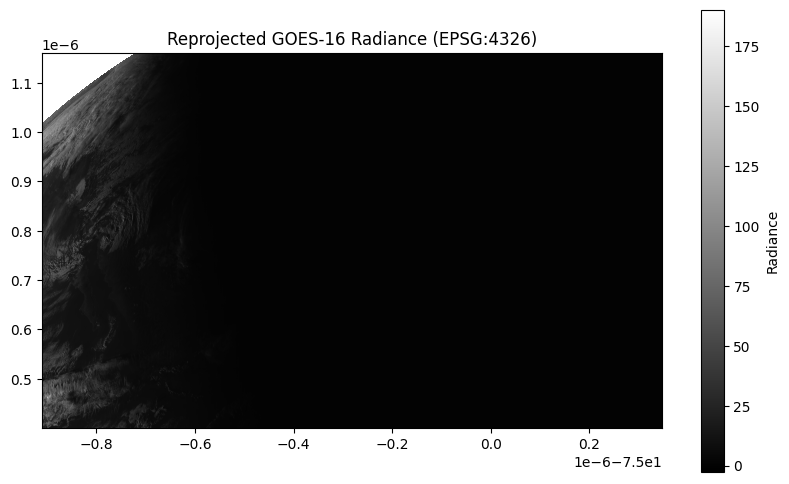

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Reprojected GOES-16 Radiance (EPSG:4326)")
plt.imshow(reprojected_radiance, extent=(dst_transform[2], dst_transform[2] + dst_transform[0] * width, dst_transform[5] + dst_transform[4] * height, dst_transform[5]), origin='upper', cmap='gray')
plt.colorbar(label="Radiance")
plt.show()